## Dresslar CAS522 M2 Notebook


In [35]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

> Question 1: Define a python function that generates the adjacency matrix of a random (Erdos-Renyi) graph with N nodes and probability p.

In [36]:
def ER_adj_matrix(N,p):
    """
    Create an adjacency matrix for a random E-R graph with N nodes and probability p.
    For example, if N=3 and p=0.5, we might have:

    [[0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]]

    Note that a tricky aspect is that the matrix is to be symmetric (undirected) and so we need to set one triangle and
    reflect it into the other.
    """
    A = np.zeros((N,N), dtype=int)
    for i in range(N):
        for j in range(i+1, N): # just do the "top" triangle. i+1 includes an offset.
            if np.random.rand() < p:
                A[i,j] = 1
                A[j,i] = 1 # reflection!
                    
    return A

Testing the function:

In [37]:
n = 100 # a very large number here will make things slow.
p = 0.2 # please chose a number between 0 and 1.

A = ER_adj_matrix(n,p)

print(A)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


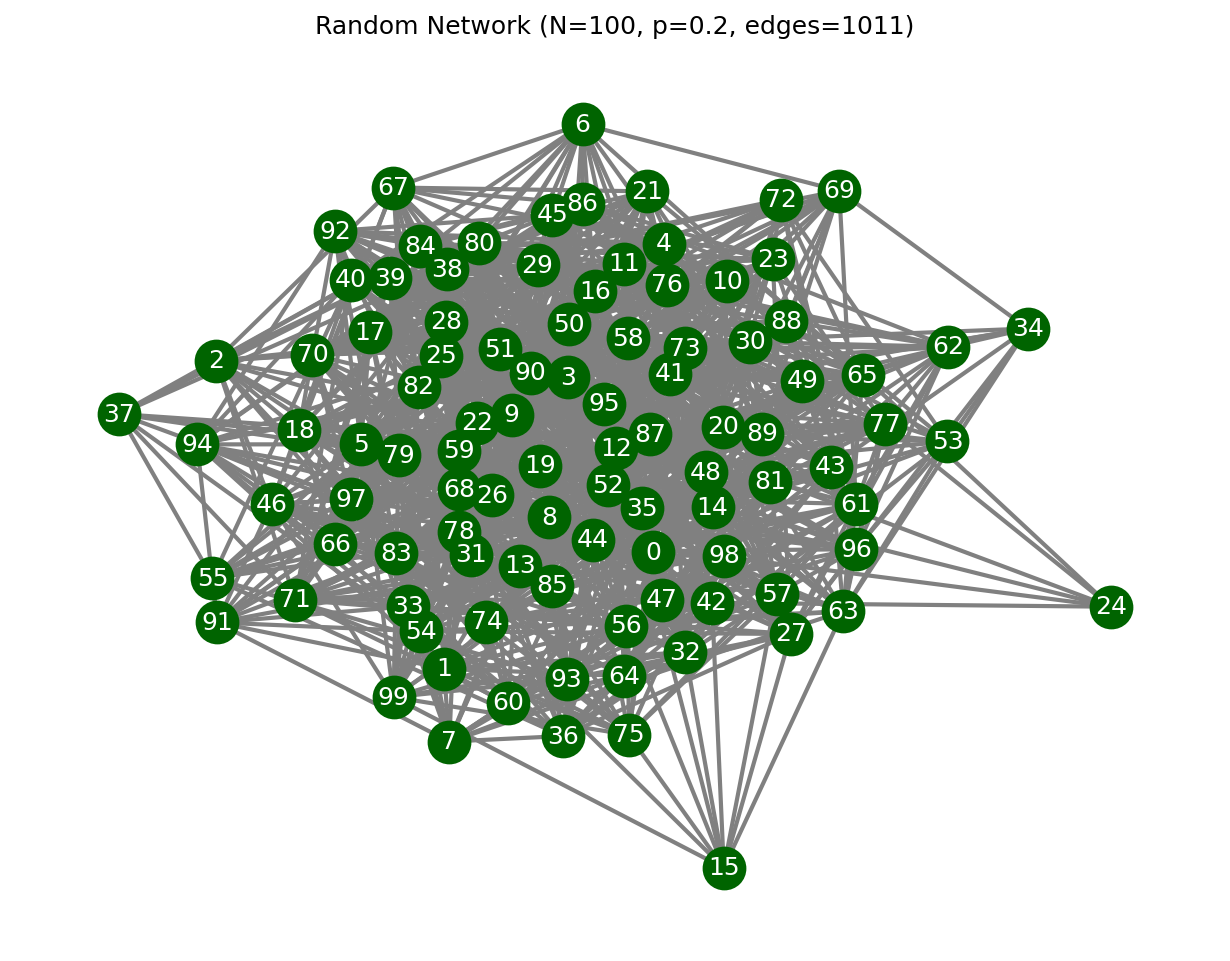

In [38]:
def get_and_plot_network_from_matrix(A):
    # see: https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_array.html
    G = nx.from_numpy_array(np.array(A))
    
    # layout. see: https://networkx.org/documentation/stable/auto_examples/drawing/plot_spring_layout.html
    pos = nx.spring_layout(G, seed=112358)
    
    # Plot
    plt.figure(figsize=(8, 6), dpi=150)
    nx.draw(G, pos, 
            node_size=400, 
            node_color='darkgreen', 
            edge_color='gray',
            with_labels=True, 
            font_color='white',
            font_size=12,
            width=2)
    plt.title(f"Random Network (N={len(A)}, p={p}, edges={G.number_of_edges()})")
    plt.axis('off')
    plt.show()

    return G

G = get_and_plot_network_from_matrix(A)

#### Q2

> Define a python function that calculates the average clustering coefficient *C* of a random network with adjacency matrix *A* as defined in the previous question. Test your function by changing the inputs *N* and *p*. Can you verify that your function produces the intended results?

In [41]:
# for reference:
print(f"Network A has {A.shape[0]} nodes using probability {p} for edges.")

# here, we can somewhat cheat a bit, since netorkx gives us a function straight out of the box:
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clustering_coefficient.average_clustering.html
# (Note the E-R graph at the bottom of that document!)

# we still have G from the previous question, so we could use it here:

print(f"Networkx's average clustering coefficient: {nx.average_clustering(G)}")

# we could also have used the nodes in A, and we can try that here: (note that this could get slow for large matrices, as we are not sampling.)

def av_clust_coeff_from_np_matrix(A):
    """
    Calculate the average clustering coefficient of a network from an adjacency matrix.
    """

    # get the number of nodes, or, in other words, the length of the "side" of the matrix
    N = A.shape[0]

    # initialize the average clustering coefficient
    locals = []

    for i in range(N):
        # get the neighbors of node i
        # there is an easier way to do this with np, but...
        neighbors = []
        for j in range(N):
            if A[i,j] == 1:
                neighbors.append(j)

        # get the number of neighbors
        k_sub_i = len(neighbors)

        # now we need to get the number of edges belonging to the neighbors in neighbors
        E_sub_i = 0
        for j in neighbors:
            for k in neighbors:
                if A[j,k] == 1:
                    E_sub_i += 1

        # zero div check
        if k_sub_i < 2: # either 1 or 0 will give us a zero div
            locals.append(0)
            continue
        
        C_sub_i = E_sub_i / (k_sub_i * (k_sub_i - 1))
        locals.append(C_sub_i)

    C = np.mean(locals)

    return C

# comment the following out for big matrices!!
print(f"Manual average clustering coefficient: {av_clust_coeff_from_np_matrix(A)}")







Network A has 100 nodes using probability 0.2 for edges.
Networkx's average clustering coefficient: 0.2018809968370717
Manual average clustering coefficient: 0.20188099683707184


Hey! They match up pretty closely! That's cool!

It seems a little unfair to have used a library, here, but perhaps a good thing to do next would be to explore a (small!) model space for different values of R and n using our handy `average_clustering` tool.

In [47]:
# define N sweep range and interval
N_min = 10
N_max = 20
N_step = 10

# define p sweep range and interval
p_min = 0.05
p_max = 0.10
p_step = 0.05

# create empty lists to store results (results will be the value C)
N_list = list(np.arange(N_min, N_max + 1, N_step)) # integer values
p_list = list(np.arange(p_min, p_max + 1, p_step)) # float values

C_list = []

for N in N_list:
    print(f"N: {N}")
    for p in p_list:
        print(f"p: {p}")
        A = ER_adj_matrix(N,p)
        G = nx.from_numpy_array(np.array(A)) # so we can use networkx's average clustering coefficient
        C = nx.average_clustering(G) # sampling may be faster
        C_list.append(C)



N: 10
p: 0.05
p: 0.1
p: 0.15000000000000002
p: 0.2
p: 0.25
p: 0.30000000000000004
p: 0.35000000000000003
p: 0.4
p: 0.45
p: 0.5
p: 0.55
p: 0.6000000000000001
p: 0.65
p: 0.7000000000000001
p: 0.75
p: 0.8
p: 0.8500000000000001
p: 0.9
p: 0.9500000000000001
p: 1.0
p: 1.05
N: 20
p: 0.05
p: 0.1
p: 0.15000000000000002
p: 0.2
p: 0.25
p: 0.30000000000000004
p: 0.35000000000000003
p: 0.4
p: 0.45
p: 0.5
p: 0.55
p: 0.6000000000000001
p: 0.65
p: 0.7000000000000001
p: 0.75
p: 0.8
p: 0.8500000000000001
p: 0.9
p: 0.9500000000000001
p: 1.0
p: 1.05
